In [1]:
import os
import json
import pandas as pd
from deside.utility import (check_dir, sorted_cell_types)
from deside.utility.read_file import ReadExp, ReadH5AD
from deside.simulation import (BulkGEPGenerator, get_gene_list_for_filtering,
                               filtering_by_gene_list_and_pca_plot)

2024-02-02 10:30:48.939631: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Synthesizing bulk tumors
- Using the synthesis of a filtered bulk GEPs dataset with 8,000 samples as an example.
- Two filtering steps, GEP-filteirng and Gene-filtering, will be demonstrated.
- Instead of using the raw integrated scRNA-seq dataset `S0`, we will use the `S1` dataset directly.

- MacOS (this example): 6-Core Intel Core i5, 32 GB memory
- For larger sample size, more memory is needed, we synthesized dataset `D1` and `D2` on a computing server.

In [2]:
# the list of 12 single cell RNA-seq datasets
sc_dataset_ids = ['hnscc_cillo_01', 'pdac_pengj_02', 'hnscc_puram_03',
                  'pdac_steele_04', 'luad_kim_05', 'nsclc_guo_06', 
                  'pan_cancer_07', 'prad_cheng_08', 'prad_dong_09', 
                  'hcc_sun_10', 'gbm_neftel_11', 'gbm_abdelfattah_12',]

# the list of 19 cancer types in the TCGA dataset
cancer_types = ['ACC', 'BLCA', 'BRCA', 'GBM', 'HNSC', 'LGG', 'LIHC', 'LUAD', 'PAAD', 'PRAD',
                'CESC', 'COAD', 'KICH', 'KIRC', 'KIRP', 'LUSC', 'READ', 'THCA', 'UCEC']

cancer_types_for_filtering = cancer_types.copy()

# coefficient to correct the difference of total RNA abundance in different cell types
# There is no effect to the final results if all the coefficients are set to 1
alpha_total_rna_coefficient = {'B Cells': 1.0, 'CD4 T': 1.0, 'CD8 T': 1.0, 'DC': 1.0,
                               'Endothelial Cells': 1.0, 'Cancer Cells': 1.0, 'Fibroblasts': 1.0,
                               'Macrophages': 1.0, 'Mast Cells': 1.0, 'NK': 1.0, 'Neutrophils': 1.0,
                               'Double-neg-like T': 1.0, 'Monocytes': 1.0}

# cell types and the corresponding subtypes
cell_type2subtypes = {'B Cells': ['Non-plasma B cells', 'Plasma B cells'],
                      'CD4 T': ['CD4 T'], 'CD8 T': ['CD8 T (GZMK high)', 'CD8 T effector'],
                      'DC': ['DC'], 'Endothelial Cells': ['Endothelial Cells'],
                      'Cancer Cells': ['Cancer Cells'],
                      'Fibroblasts': ['CAFs', 'Myofibroblasts'], 'Macrophages': ['Macrophages'],
                      'Mast Cells': ['Mast Cells'], 'NK': ['NK'], 'Neutrophils': ['Neutrophils'],
                      'Double-neg-like T': ['Double-neg-like T'], 'Monocytes': ['Monocytes']}

# the list of cell types
all_cell_types = sorted([i for v in cell_type2subtypes.values() for i in v])
all_cell_types = [i for i in sorted_cell_types if i in all_cell_types]
all_cell_types

['Plasma B cells',
 'Non-plasma B cells',
 'CD4 T',
 'CD8 T effector',
 'CD8 T (GZMK high)',
 'Double-neg-like T',
 'Cancer Cells',
 'DC',
 'Endothelial Cells',
 'CAFs',
 'Myofibroblasts',
 'Macrophages',
 'Mast Cells',
 'NK',
 'Neutrophils',
 'Monocytes']

#### Parameters

In [3]:
# parameters
# for gene-level filtering
gene_list_type = 'high_corr_gene_and_quantile_range'
gene_quantile_range = [0.005, 0.5, 0.995]  # gene-level filtering

# for GEP-level filtering
gep_filtering_quantile = (0.0, 0.95)  # GEP-level filtering, L1-norm threshold
filtering_in_pca_space = True
pca_n_components = 0.9
n_base = 100  # averaging 100 GEPs sampled from S1 to synthesize 1 bulk GEP, used by S1 generation

# optional, if set a prior cell proportion range for each cell type, the GEP-filtering step will be faster, default is (0, 1)
# It can be set as cell_prop_prior = {'B Cells': (0, 0.25), 'CD4 T': (0, 0.25), 'CD8 T': (0, 0.25),
#                    'DC': (0, 0.1), 'Mast Cells': (0, 0.1), 'NK': (0, 0.1), 'Neutrophils': (0, 0.1),
#                    'Endothelial Cells': (0, 0.5), 'Fibroblasts': (0, 0.5), 'Macrophages': (0, 0.5),
#                    'Cancer Cells': (0, 1)}
cell_prop_prior = None
dataset2parameters = {
    'Mixed_N10K_segment': {
        'sc_dataset_ids': sc_dataset_ids,
        'cell_type2subtype': cell_type2subtypes,
        'n_samples': 8000,
        'sampling_method': 'segment', # or `random` used by Scaden
        'filtering': True,
    }
}

for ds, params in dataset2parameters.items():
    if ('filtering' in params) and ('filtering_ref_types' not in params):
        if params['filtering']:
            params['filtering_ref_types'] = cancer_types_for_filtering
        else:
            params['filtering_ref_types'] = []
print(json.dumps(dataset2parameters, indent=2))

{
  "Mixed_N10K_segment": {
    "sc_dataset_ids": [
      "hnscc_cillo_01",
      "pdac_pengj_02",
      "hnscc_puram_03",
      "pdac_steele_04",
      "luad_kim_05",
      "nsclc_guo_06",
      "pan_cancer_07",
      "prad_cheng_08",
      "prad_dong_09",
      "hcc_sun_10",
      "gbm_neftel_11",
      "gbm_abdelfattah_12"
    ],
    "cell_type2subtype": {
      "B Cells": [
        "Non-plasma B cells",
        "Plasma B cells"
      ],
      "CD4 T": [
        "CD4 T"
      ],
      "CD8 T": [
        "CD8 T (GZMK high)",
        "CD8 T effector"
      ],
      "DC": [
        "DC"
      ],
      "Endothelial Cells": [
        "Endothelial Cells"
      ],
      "Cancer Cells": [
        "Cancer Cells"
      ],
      "Fibroblasts": [
        "CAFs",
        "Myofibroblasts"
      ],
      "Macrophages": [
        "Macrophages"
      ],
      "Mast Cells": [
        "Mast Cells"
      ],
      "NK": [
        "NK"
      ],
      "Neutrophils": [
        "Neutrophils"
      ],
      

#### Input files
- `merged_tpm.csv`: Gene expression profiles (GEPs) of 19 cancer types in TCGA (TPM format). Download link: https://doi.org/10.6084/m9.figshare.23047547.v1
- `tcga_sample_id2cancer_type.csv`: An annotation file that contains the cancer type for each sample id of above 19 cancer types.
- `simu_bulk_exp_SCT_N10K_S1_16sct.h5ad`: Dataset S1, which contains the synthesized single-cell-type GEPs (sctGEPs). Download link: https://doi.org/10.6084/m9.figshare.23043560.v2

In [4]:
# Using TCGA as reference GEPs to filter synthetic GEPs 
tcga_data_dir = r'./datasets/TCGA/tpm/'  # input
tcga_merged_tpm_file_path = os.path.join(tcga_data_dir, 'merged_tpm.csv')
tcga2cancer_type_file_path = os.path.join(tcga_data_dir, 'tcga_sample_id2cancer_type.csv')

In [5]:
# the file path of the dataset `S1`
sct_dataset_file_path = './datasets/simu_bulk_exp_SCT_N10K_S1_16sct.h5ad'

In [6]:
# naming the file of filtered bulk cell dataset
q_names = ['q_' + str(int(q * 1000)/10) for q in gene_quantile_range]
replace_by = f'_filtered_by_{gene_list_type}.h5ad'
high_corr_gene_list = []
if 'quantile_range' in gene_list_type:
    replace_by = f'_filtered_by_{gene_list_type}_{q_names[0]}_{q_names[2]}.h5ad'
replace_by

'_filtered_by_high_corr_gene_and_quantile_range_q_0.5_q_99.5.h5ad'

In [7]:
sampling_method2dir = {
    'random': os.path.join('results', 'E3', '{}_{}ds_n_base{}'),
    'segment': os.path.join('results', 'E3', '{}_{}ds_{}_n_base{}_median_gep'),
}

#### Bulk GEP generation and GEP-filtering
- This step will take about 1.5 hours for 8,000 samples

In [8]:
n_sc_datasets = len(sc_dataset_ids)
dataset2path = {}
log_file_path = './results/E3/DeSide_running_log.txt'
for dataset_name, params in dataset2parameters.items():
    if 'SCT' in dataset_name:
        pass  # using `S1` directly, omit this step here
    else:
        sampling_method = params['sampling_method']
        # the folder of simulated bulk cells
        simu_bulk_exp_dir = sampling_method2dir[sampling_method]
        if sampling_method in ['segment', 'dirichlet']:
            if params['filtering']:
                _postfix_filtered_ds_naming = f'_{len(cancer_types_for_filtering)}cancer'
                if filtering_in_pca_space:
                    _postfix_filtered_ds_naming += f'_pca_{pca_n_components}'
                simu_bulk_exp_dir = simu_bulk_exp_dir.format(sampling_method, n_sc_datasets,
                                                             gep_filtering_quantile[1],
                                                             str(n_base) + _postfix_filtered_ds_naming)
            else:
                simu_bulk_exp_dir = simu_bulk_exp_dir.format(sampling_method, n_sc_datasets, 'no_filtering', n_base)
        else:  # 'random'
            simu_bulk_exp_dir = simu_bulk_exp_dir.format(sampling_method, n_sc_datasets, n_base)
        check_dir(simu_bulk_exp_dir)
        
        bulk_generator = BulkGEPGenerator(simu_bulk_dir=simu_bulk_exp_dir,
                                          merged_sc_dataset_file_path=None,
                                          cell_type2subtype=params['cell_type2subtype'],
                                          sc_dataset_ids=params['sc_dataset_ids'],
                                          bulk_dataset_name=dataset_name,
                                          sct_dataset_file_path=sct_dataset_file_path,
                                          check_basic_info=False,
                                          tcga2cancer_type_file_path=tcga2cancer_type_file_path,
                                          total_rna_coefficient=alpha_total_rna_coefficient,
                                          cell_type_col_name='cell_type',
                                          subtype_col_name='cell_type')
        # GEP-filtering will be performed during this generation process
        generated_bulk_gep_fp = bulk_generator.generated_bulk_gep_fp
        dataset2path[dataset_name] = generated_bulk_gep_fp
        if not os.path.exists(generated_bulk_gep_fp):
            bulk_generator.generate_gep(n_samples=params['n_samples'],
                                        simu_method='mul',
                                        sampling_method=params['sampling_method'],
                                        reference_file=tcga_merged_tpm_file_path,
                                        ref_exp_type='TPM',
                                        filtering=params['filtering'],
                                        filtering_ref_types=params['filtering_ref_types'],
                                        gep_filtering_quantile=gep_filtering_quantile,
                                        n_threads=5,
                                        log_file_path=log_file_path,
                                        show_filtering_info=False,
                                        filtering_method='median_gep',
                                        cell_prop_prior=cell_prop_prior,
                                        filtering_in_pca_space=filtering_in_pca_space,
                                        norm_ord=1, pca_n_components=pca_n_components)

   > 7699 samples in ACC, BLCA, BRCA, GBM, HNSC, LGG, LIHC, LUAD, PAAD, PRAD, CESC, COAD, KICH, KIRC, KIRP, LUSC, READ, THCA, UCEC are used for median_gep filtering.


  0%|                                                                                     | 0/8000 [00:00<?, ?it/s]2024-02-02 10:40:12.634407: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 10:40:12.634408: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 10:40:12.634408: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructio

   > The following total RNA coefficient will be used:  {'CAFs': 1.0, 'CD4 T': 1.0, 'CD8 T (GZMK high)': 1.0, 'CD8 T effector': 1.0, 'Cancer Cells': 1.0, 'DC': 1.0, 'Double-neg-like T': 1.0, 'Endothelial Cells': 1.0, 'Macrophages': 1.0, 'Mast Cells': 1.0, 'Monocytes': 1.0, 'Myofibroblasts': 1.0, 'NK': 1.0, 'Neutrophils': 1.0, 'Non-plasma B cells': 1.0, 'Plasma B cells': 1.0}
   17832 common genes will be used, 1880 genes will be removed.
   2 genes are not in current dataset, 0 will be filled
   > 576 dimensions are needed to explain 90.00118374824524% variance.


  7%|████▊                                                                    | 532/8000 [10:14<2:23:47,  1.16s/it]2024-02-02 10:49:40.466072: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 10:49:40.485373: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 10:49:40.565789: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructio

   > The following total RNA coefficient will be used:  {'CAFs': 1.0, 'CD4 T': 1.0, 'CD8 T (GZMK high)': 1.0, 'CD8 T effector': 1.0, 'Cancer Cells': 1.0, 'DC': 1.0, 'Double-neg-like T': 1.0, 'Endothelial Cells': 1.0, 'Macrophages': 1.0, 'Mast Cells': 1.0, 'Monocytes': 1.0, 'Myofibroblasts': 1.0, 'NK': 1.0, 'Neutrophils': 1.0, 'Non-plasma B cells': 1.0, 'Plasma B cells': 1.0}


 14%|█████████▊                                                              | 1090/8000 [15:53<1:35:12,  1.21it/s]2024-02-02 10:55:21.155626: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 10:55:21.155625: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 10:55:21.166982: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructio

   > The following total RNA coefficient will be used:  {'CAFs': 1.0, 'CD4 T': 1.0, 'CD8 T (GZMK high)': 1.0, 'CD8 T effector': 1.0, 'Cancer Cells': 1.0, 'DC': 1.0, 'Double-neg-like T': 1.0, 'Endothelial Cells': 1.0, 'Macrophages': 1.0, 'Mast Cells': 1.0, 'Monocytes': 1.0, 'Myofibroblasts': 1.0, 'NK': 1.0, 'Neutrophils': 1.0, 'Non-plasma B cells': 1.0, 'Plasma B cells': 1.0}


 20%|██████████████▋                                                         | 1631/8000 [21:35<1:18:24,  1.35it/s]2024-02-02 11:01:04.249210: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 11:01:04.249211: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 11:01:04.358432: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructio

   > The following total RNA coefficient will be used:  {'CAFs': 1.0, 'CD4 T': 1.0, 'CD8 T (GZMK high)': 1.0, 'CD8 T effector': 1.0, 'Cancer Cells': 1.0, 'DC': 1.0, 'Double-neg-like T': 1.0, 'Endothelial Cells': 1.0, 'Macrophages': 1.0, 'Mast Cells': 1.0, 'Monocytes': 1.0, 'Myofibroblasts': 1.0, 'NK': 1.0, 'Neutrophils': 1.0, 'Non-plasma B cells': 1.0, 'Plasma B cells': 1.0}


 27%|███████████████████▋                                                    | 2188/8000 [27:27<1:07:25,  1.44it/s]2024-02-02 11:06:57.785476: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 11:06:57.790124: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 11:06:57.886897: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructio

   > The following total RNA coefficient will be used:  {'CAFs': 1.0, 'CD4 T': 1.0, 'CD8 T (GZMK high)': 1.0, 'CD8 T effector': 1.0, 'Cancer Cells': 1.0, 'DC': 1.0, 'Double-neg-like T': 1.0, 'Endothelial Cells': 1.0, 'Macrophages': 1.0, 'Mast Cells': 1.0, 'Monocytes': 1.0, 'Myofibroblasts': 1.0, 'NK': 1.0, 'Neutrophils': 1.0, 'Non-plasma B cells': 1.0, 'Plasma B cells': 1.0}


 34%|████████████████████████▋                                               | 2740/8000 [33:35<1:00:05,  1.46it/s]2024-02-02 11:13:06.943169: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 11:13:06.975525: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 11:13:07.049581: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructio

   > The following total RNA coefficient will be used:  {'CAFs': 1.0, 'CD4 T': 1.0, 'CD8 T (GZMK high)': 1.0, 'CD8 T effector': 1.0, 'Cancer Cells': 1.0, 'DC': 1.0, 'Double-neg-like T': 1.0, 'Endothelial Cells': 1.0, 'Macrophages': 1.0, 'Mast Cells': 1.0, 'Monocytes': 1.0, 'Myofibroblasts': 1.0, 'NK': 1.0, 'Neutrophils': 1.0, 'Non-plasma B cells': 1.0, 'Plasma B cells': 1.0}


 41%|██████████████████████████████▌                                           | 3301/8000 [39:41<52:47,  1.48it/s]2024-02-02 11:19:11.817903: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 11:19:11.832303: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 11:19:11.899776: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructio

   > The following total RNA coefficient will be used:  {'CAFs': 1.0, 'CD4 T': 1.0, 'CD8 T (GZMK high)': 1.0, 'CD8 T effector': 1.0, 'Cancer Cells': 1.0, 'DC': 1.0, 'Double-neg-like T': 1.0, 'Endothelial Cells': 1.0, 'Macrophages': 1.0, 'Mast Cells': 1.0, 'Monocytes': 1.0, 'Myofibroblasts': 1.0, 'NK': 1.0, 'Neutrophils': 1.0, 'Non-plasma B cells': 1.0, 'Plasma B cells': 1.0}


 48%|███████████████████████████████████▌                                      | 3849/8000 [45:36<46:01,  1.50it/s]2024-02-02 11:25:05.182736: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 11:25:05.212881: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 11:25:05.235608: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructio

   > The following total RNA coefficient will be used:  {'CAFs': 1.0, 'CD4 T': 1.0, 'CD8 T (GZMK high)': 1.0, 'CD8 T effector': 1.0, 'Cancer Cells': 1.0, 'DC': 1.0, 'Double-neg-like T': 1.0, 'Endothelial Cells': 1.0, 'Macrophages': 1.0, 'Mast Cells': 1.0, 'Monocytes': 1.0, 'Myofibroblasts': 1.0, 'NK': 1.0, 'Neutrophils': 1.0, 'Non-plasma B cells': 1.0, 'Plasma B cells': 1.0}


 55%|████████████████████████████████████████▌                                 | 4380/8000 [51:39<40:28,  1.49it/s]2024-02-02 11:31:07.976645: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 11:31:08.037030: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 11:31:08.124622: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructio

   > The following total RNA coefficient will be used:  {'CAFs': 1.0, 'CD4 T': 1.0, 'CD8 T (GZMK high)': 1.0, 'CD8 T effector': 1.0, 'Cancer Cells': 1.0, 'DC': 1.0, 'Double-neg-like T': 1.0, 'Endothelial Cells': 1.0, 'Macrophages': 1.0, 'Mast Cells': 1.0, 'Monocytes': 1.0, 'Myofibroblasts': 1.0, 'NK': 1.0, 'Neutrophils': 1.0, 'Non-plasma B cells': 1.0, 'Plasma B cells': 1.0}


 62%|█████████████████████████████████████████████▉                            | 4960/8000 [57:33<32:59,  1.54it/s]2024-02-02 11:37:02.399277: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 11:37:02.429091: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 11:37:02.529606: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructio

   > The following total RNA coefficient will be used:  {'CAFs': 1.0, 'CD4 T': 1.0, 'CD8 T (GZMK high)': 1.0, 'CD8 T effector': 1.0, 'Cancer Cells': 1.0, 'DC': 1.0, 'Double-neg-like T': 1.0, 'Endothelial Cells': 1.0, 'Macrophages': 1.0, 'Mast Cells': 1.0, 'Monocytes': 1.0, 'Myofibroblasts': 1.0, 'NK': 1.0, 'Neutrophils': 1.0, 'Non-plasma B cells': 1.0, 'Plasma B cells': 1.0}


 68%|█████████████████████████████████████████████████▏                      | 5472/8000 [1:03:18<27:43,  1.52it/s]2024-02-02 11:42:48.423503: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 11:42:48.456038: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 11:42:48.538984: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructio

   > The following total RNA coefficient will be used:  {'CAFs': 1.0, 'CD4 T': 1.0, 'CD8 T (GZMK high)': 1.0, 'CD8 T effector': 1.0, 'Cancer Cells': 1.0, 'DC': 1.0, 'Double-neg-like T': 1.0, 'Endothelial Cells': 1.0, 'Macrophages': 1.0, 'Mast Cells': 1.0, 'Monocytes': 1.0, 'Myofibroblasts': 1.0, 'NK': 1.0, 'Neutrophils': 1.0, 'Non-plasma B cells': 1.0, 'Plasma B cells': 1.0}


 75%|██████████████████████████████████████████████████████▎                 | 6031/8000 [1:09:28<21:37,  1.52it/s]2024-02-02 11:48:58.020282: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 11:48:58.020497: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 11:48:58.078821: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructio

   > The following total RNA coefficient will be used:  {'CAFs': 1.0, 'CD4 T': 1.0, 'CD8 T (GZMK high)': 1.0, 'CD8 T effector': 1.0, 'Cancer Cells': 1.0, 'DC': 1.0, 'Double-neg-like T': 1.0, 'Endothelial Cells': 1.0, 'Macrophages': 1.0, 'Mast Cells': 1.0, 'Monocytes': 1.0, 'Myofibroblasts': 1.0, 'NK': 1.0, 'Neutrophils': 1.0, 'Non-plasma B cells': 1.0, 'Plasma B cells': 1.0}


 82%|██████████████████████████████████████████████████████████▉             | 6552/8000 [1:15:22<16:02,  1.50it/s]2024-02-02 11:54:48.779628: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 11:54:48.816384: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 11:54:48.882257: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructio

   > The following total RNA coefficient will be used:  {'CAFs': 1.0, 'CD4 T': 1.0, 'CD8 T (GZMK high)': 1.0, 'CD8 T effector': 1.0, 'Cancer Cells': 1.0, 'DC': 1.0, 'Double-neg-like T': 1.0, 'Endothelial Cells': 1.0, 'Macrophages': 1.0, 'Mast Cells': 1.0, 'Monocytes': 1.0, 'Myofibroblasts': 1.0, 'NK': 1.0, 'Neutrophils': 1.0, 'Non-plasma B cells': 1.0, 'Plasma B cells': 1.0}


 89%|████████████████████████████████████████████████████████████████        | 7114/8000 [1:21:00<09:31,  1.55it/s]2024-02-02 12:00:29.313266: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 12:00:29.335441: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 12:00:29.403994: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructio

   > The following total RNA coefficient will be used:  {'CAFs': 1.0, 'CD4 T': 1.0, 'CD8 T (GZMK high)': 1.0, 'CD8 T effector': 1.0, 'Cancer Cells': 1.0, 'DC': 1.0, 'Double-neg-like T': 1.0, 'Endothelial Cells': 1.0, 'Macrophages': 1.0, 'Mast Cells': 1.0, 'Monocytes': 1.0, 'Myofibroblasts': 1.0, 'NK': 1.0, 'Neutrophils': 1.0, 'Non-plasma B cells': 1.0, 'Plasma B cells': 1.0}


 96%|█████████████████████████████████████████████████████████████████████   | 7675/8000 [1:26:42<03:26,  1.58it/s]2024-02-02 12:06:10.969727: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 12:06:11.021545: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 12:06:11.081303: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructio

   > The following total RNA coefficient will be used:  {'CAFs': 1.0, 'CD4 T': 1.0, 'CD8 T (GZMK high)': 1.0, 'CD8 T effector': 1.0, 'Cancer Cells': 1.0, 'DC': 1.0, 'Double-neg-like T': 1.0, 'Endothelial Cells': 1.0, 'Macrophages': 1.0, 'Mast Cells': 1.0, 'Monocytes': 1.0, 'Myofibroblasts': 1.0, 'NK': 1.0, 'Neutrophils': 1.0, 'Non-plasma B cells': 1.0, 'Plasma B cells': 1.0}


100%|████████████████████████████████████████████████████████████████████████| 8000/8000 [1:32:47<00:00,  1.44it/s]


   > Got 8000 samples from 75000 within l1 distance between 878.0538330078125 and 1939.3423095703124 by quantile 0.0%-95.0%

---->>> <class 'deside.simulation.generate_data.BulkGEPGenerator'>:
{
  "simu_bulk_dir": "results/E3/segment_12ds_0.95_n_base100_19cancer_pca_0.9_median_gep",
  "cell_type_used": [
    "B Cells",
    "CD4 T",
    "CD8 T",
    "DC",
    "Endothelial Cells",
    "Cancer Cells",
    "Fibroblasts",
    "Macrophages",
    "Mast Cells",
    "NK",
    "Neutrophils",
    "Double-neg-like T",
    "Monocytes"
  ],
  "cell_subtype_used": [
    "Non-plasma B cells",
    "Plasma B cells",
    "CD8 T (GZMK high)",
    "CD8 T effector",
    "CAFs",
    "Myofibroblasts"
  ],
  "sc_dataset_used": [
    "hnscc_cillo_01",
    "pdac_pengj_02",
    "hnscc_puram_03",
    "pdac_steele_04",
    "luad_kim_05",
    "nsclc_guo_06",
    "pan_cancer_07",
    "prad_cheng_08",
    "prad_dong_09",
    "hcc_sun_10",
    "gbm_neftel_11",
    "gbm_abdelfattah_12"
  ],
  "bulk_dataset_name": "Mixed

#### Gene-filtering
- Highly correlated genes between the gene expression values and the cell proportions for each cell type
- Using the same gene list given by dataset D2

In [9]:
d2_dir = './datasets/simulated_bulk_cell_dataset/D2/'
high_corr_gene_file_path = os.path.join(d2_dir, f'gene_list_filtered_by_high_corr_gene.csv')
# if not os.path.exists(high_corr_gene_file_path):
#     print(f'High correlation gene list will be saved in: {high_corr_gene_file_path}')
#     high_corr_gene_list = get_gene_list_for_filtering(bulk_exp_file=generated_bulk_gep_fp,
#                                                       filtering_type='high_corr_gene',
#                                                       corr_result_fp=corr_result_fp,
#                                                       tcga_file=tcga_merged_tpm_file_path,
#                                                       quantile_range=gene_quantile_range,
#                                                       result_file_path=high_corr_gene_file_path,
#                                                       corr_threshold=0.3, n_gene_max=1000)
# else:
#     print(f'High correlation gene list file existed: {high_corr_gene_file_path}')
high_corr_gene_list = pd.read_csv(high_corr_gene_file_path)
high_corr_gene_list = high_corr_gene_list['gene_name'].to_list()
len(high_corr_gene_list)

9481

In [10]:
dataset_name = 'Mixed_N10K_segment'
params = dataset2parameters[dataset_name]

Gene list of Mixed_N10K_segment will be saved in: results/E3/segment_12ds_0.95_n_base100_19cancer_pca_0.9_median_gep/Mixed_N10K_segment/gene_list_filtered_by_quantile_range_q_0.5_q_99.5.csv
   17832 common genes will be used, 1880 genes will be removed.
   2 genes are not in current dataset, 0 will be filled
17037 genes are selected by quantile range
Filtering by gene list and PCA plot
   9028 common genes will be used, 8806 genes will be removed.
   9028 common genes will be used, 10684 genes will be removed.
Saving filtered bulk exp to file: results/E3/segment_12ds_0.95_n_base100_19cancer_pca_0.9_median_gep/simu_bulk_exp_Mixed_N10K_segment_log2cpm1p_filtered_by_high_corr_gene_and_quantile_range_q_0.5_q_99.5.h5ad
Saving as .h5ad file...


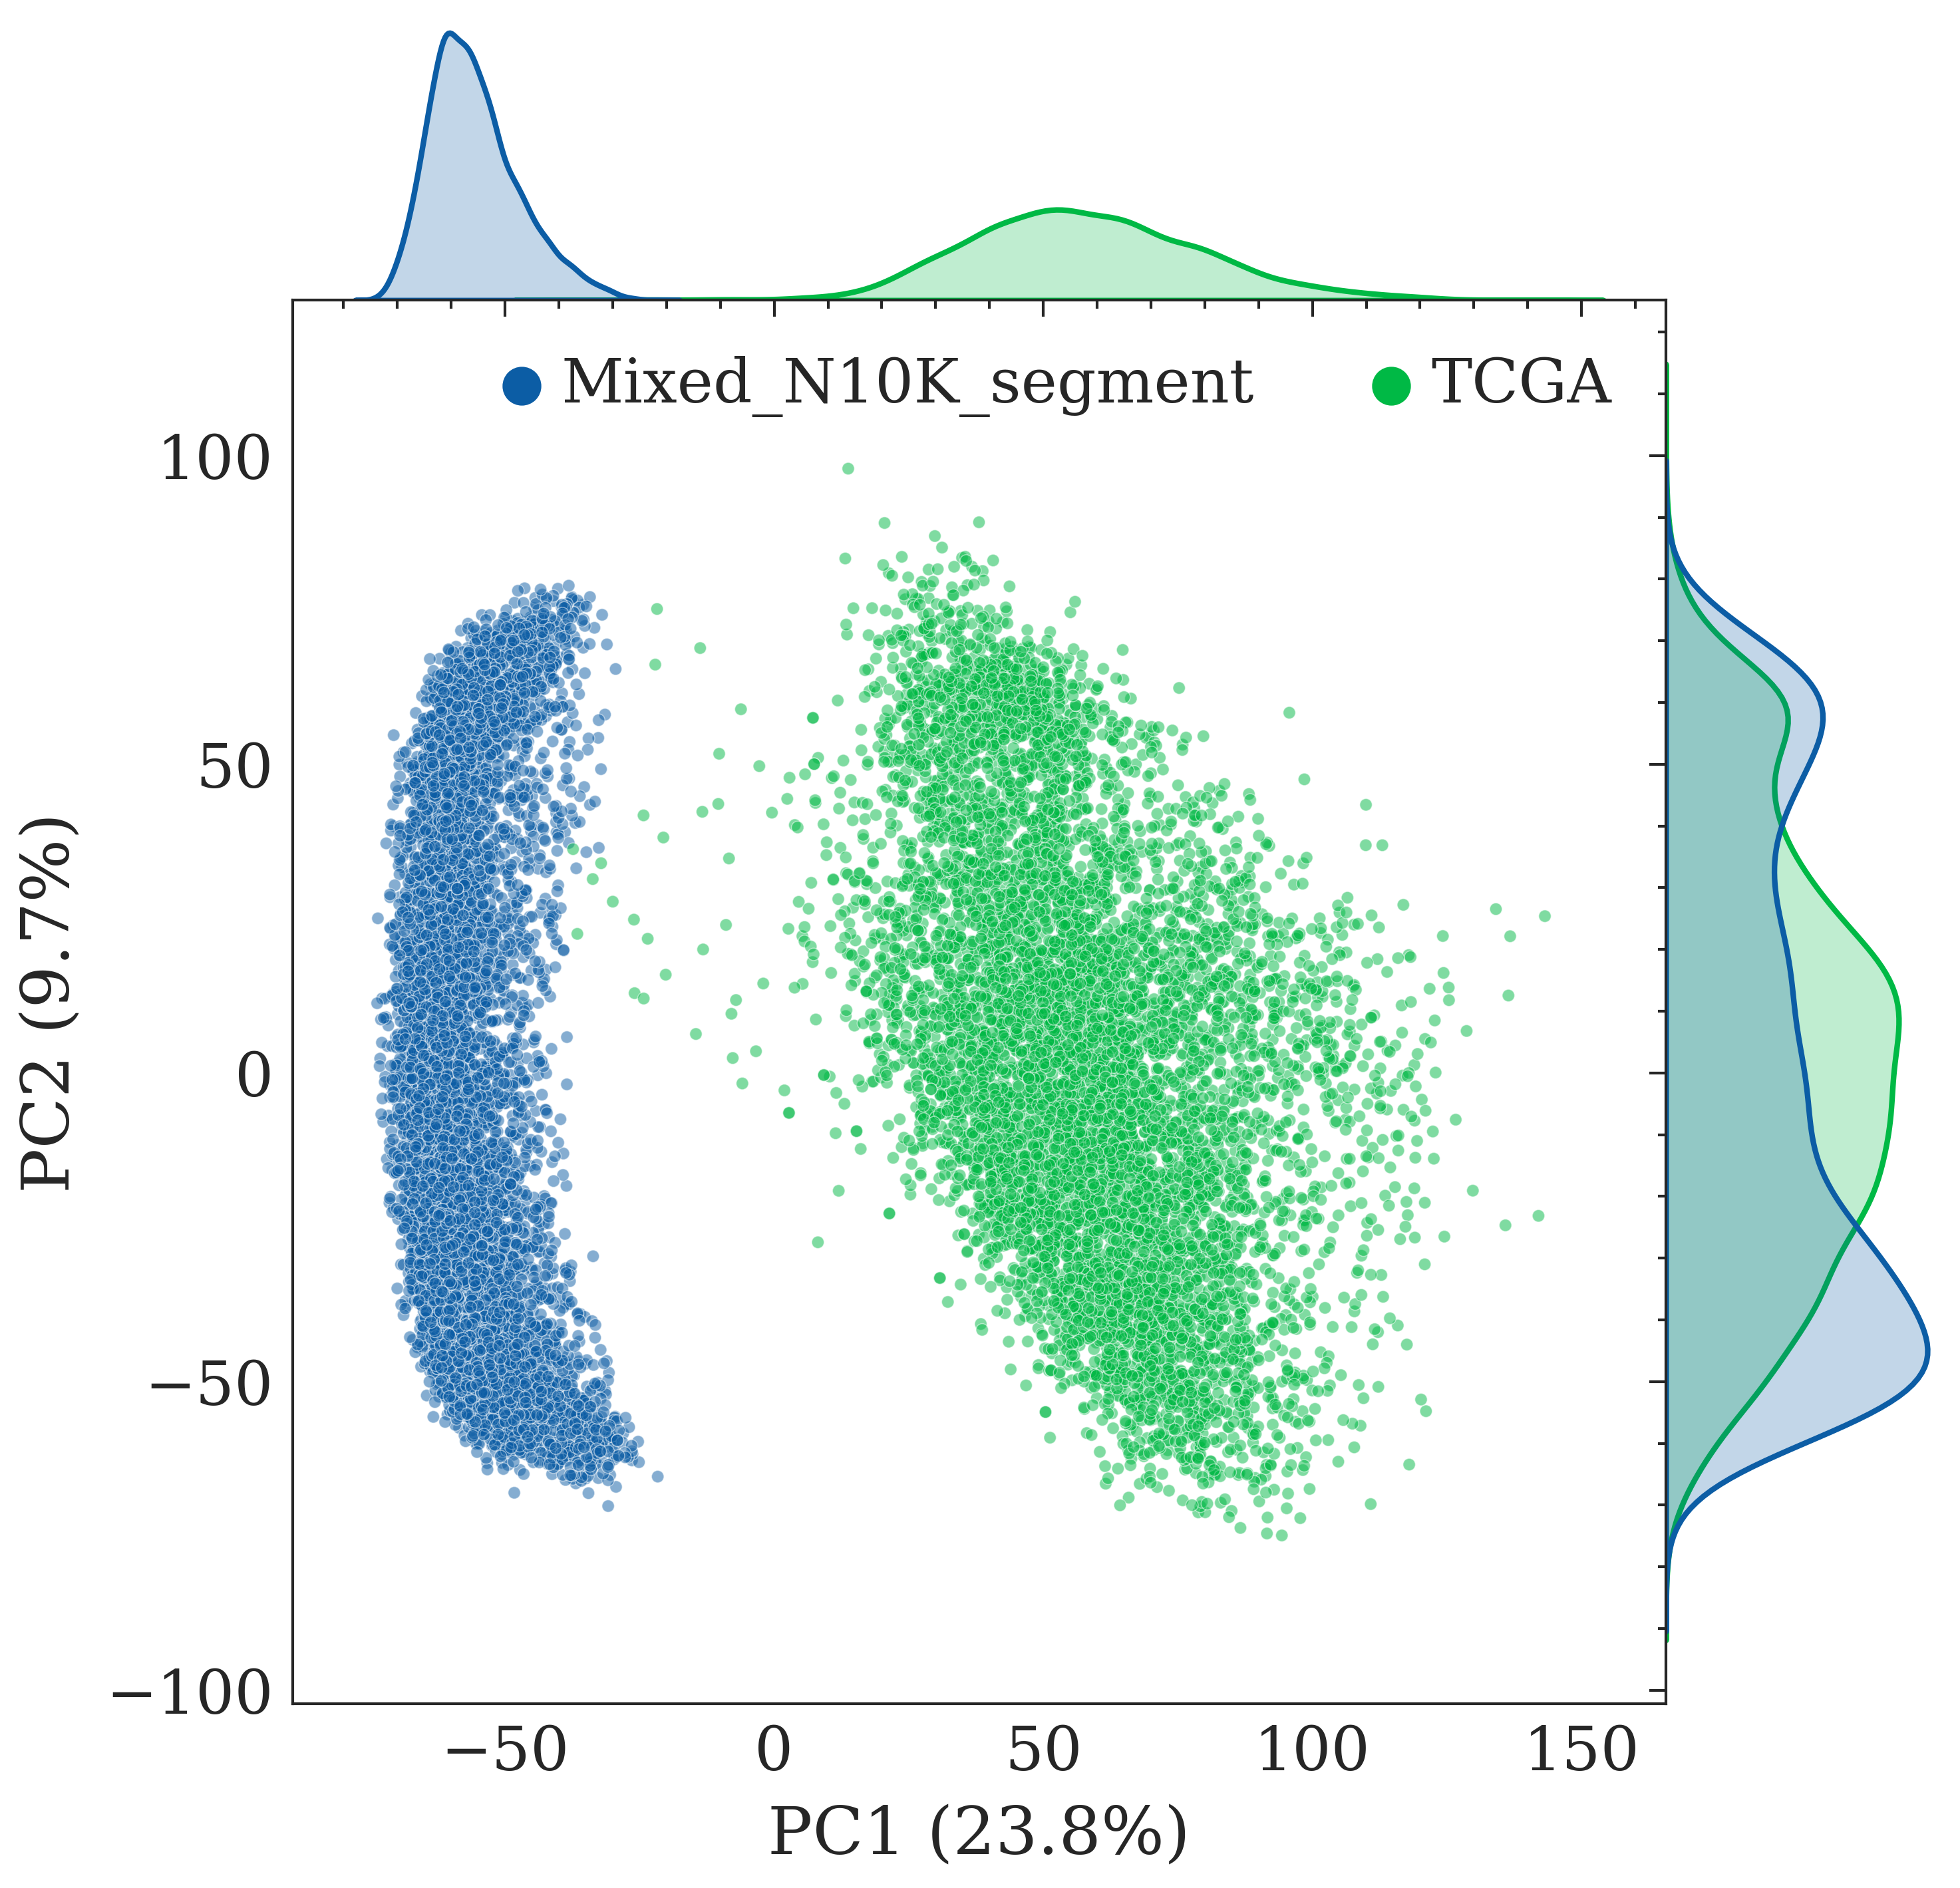

In [11]:
# gene-level filtering that depends on the high correlation genes and quantile range (each dataset itself)
if params['filtering'] and 'Mixed' in dataset_name:
    filtered_file_path = generated_bulk_gep_fp.replace('.h5ad', replace_by)
    if not os.path.exists(filtered_file_path):
        gene_list = high_corr_gene_list.copy()
        # get gene list, filtering, PCA and plot
        current_result_dir = os.path.join(simu_bulk_exp_dir, dataset_name)
        check_dir(current_result_dir)
        # the gene list file for current dataset
        if 'quantile_range' in gene_list_type:
            gene_list_file_path = os.path.join(simu_bulk_exp_dir, dataset_name, 
                                               'gene_list_filtered_by_quantile_range.csv')
            gene_list_file_path = gene_list_file_path.replace('.csv', f'_{q_names[0]}_{q_names[2]}.csv')
            if not os.path.exists(gene_list_file_path):
                print(f'Gene list of {dataset_name} will be saved in: {gene_list_file_path}')
                quantile_gene_list = get_gene_list_for_filtering(bulk_exp_file=generated_bulk_gep_fp,
                                                                 filtering_type='quantile_range',
                                                                 tcga_file=tcga_merged_tpm_file_path,
                                                                 quantile_range=gene_quantile_range,
                                                                 result_file_path=gene_list_file_path,
                                                                 q_col_name=q_names)
            else:
                print(f'Gene list file existed: {gene_list_file_path}')
                quantile_gene_list = pd.read_csv(gene_list_file_path)
                quantile_gene_list = quantile_gene_list['gene_name'].to_list()
            # get the intersection of the two gene lists (high correlation genes and within quantile range)
            gene_list = [gene for gene in gene_list if gene in quantile_gene_list]
        # save the filtered gene list
        gene_list_file_path = os.path.join(simu_bulk_exp_dir, dataset_name,
                                           f'gene_list_filtered_by_{gene_list_type}.csv')
        pd.DataFrame({'gene_name': gene_list}).to_csv(gene_list_file_path, index=False)
        
        bulk_exp_obj = ReadH5AD(generated_bulk_gep_fp)
        bulk_exp = bulk_exp_obj.get_df()
        bulk_exp_cell_frac = bulk_exp_obj.get_cell_fraction()
        tcga_exp = ReadExp(tcga_merged_tpm_file_path, exp_type='TPM').get_exp()
        pc_file_name = f'both_TCGA_and_simu_data_{dataset_name}'
        pca_model_file_path = os.path.join(current_result_dir, f'{pc_file_name}_PCA_{gene_list_type}.joblib')
        pca_data_file_path = os.path.join(current_result_dir, f'{dataset_name}_PCA_with_TCGA_{gene_list_type}.csv')
        # save GEPs data by filtered gene list
        print('Filtering by gene list and PCA plot')
        filtering_by_gene_list_and_pca_plot(bulk_exp=bulk_exp, tcga_exp=tcga_exp, gene_list=gene_list,
                                            result_dir=current_result_dir, n_components=2,
                                            simu_dataset_name=dataset_name,
                                            pca_model_name_postfix=gene_list_type,
                                            pca_model_file_path=pca_model_file_path,
                                            pca_data_file_path=pca_data_file_path,
                                            h5ad_file_path=filtered_file_path,
                                            cell_frac_file=bulk_exp_cell_frac,
                                            figsize=(5, 5))

#### Fit PCA model by simulated dataset (same as Fig. 1e)
- The previous figure showed the PCA model fitted by combining simulated dataset and TCGA

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from deside.utility import do_pca_analysis

def get_pc_simu_bulk_with_tcga(simu_ds_name, ds_file_path, tcga_exp, pca_model_file_path, n_simu_samples=None, n_components=2, t_sne=False, pca_data='simu_bulk'):
    inx2class = {}
    simu_bulk_exp_obj = ReadH5AD(ds_file_path)
    simu_bulk_exp = simu_bulk_exp_obj.get_df()
    if n_simu_samples is not None and n_simu_samples <= simu_bulk_exp.shape[0]:
        simu_bulk_exp = simu_bulk_exp.iloc[range(n_simu_samples), :].copy()
    common_genes = [i for i in simu_bulk_exp.columns.to_list() if i in tcga_exp.columns]
    
    bulk_obj = ReadExp(simu_bulk_exp, exp_type='log_space')
    bulk_obj.align_with_gene_list(gene_list=common_genes)
    bulk_exp = bulk_obj.get_exp()

    tcga_obj = ReadExp(tcga_exp, exp_type='TPM')
    tcga_obj.align_with_gene_list(gene_list=common_genes)
    tcga_obj.to_log2cpm1p()
    tcga_exp_new = tcga_obj.get_exp()
    
    bulk_exp = bulk_exp.sample(tcga_exp_new.shape[0], random_state=42)
    simu_bulk_with_tcga = pd.concat([bulk_exp, tcga_exp_new])
    # simu_bulk_with_tcga = simu_bulk_with_tcga.iloc[range(1500), range(600)].copy()
    print(simu_bulk_with_tcga.shape)
    # print(simu_bulk_with_tcga.head(2))
    if pca_data == 'TCGA':
        pca_model = do_pca_analysis(exp_df=tcga_exp_new, n_components=n_components,
                                pca_result_fp=pca_model_file_path, save_model=True)
    elif pca_data == 'simu_bulk':
        pca_model = do_pca_analysis(exp_df=bulk_exp, n_components=n_components,
                                pca_result_fp=pca_model_file_path, save_model=True)
    else:  # TCGA and simu_bulk
        pca_model = do_pca_analysis(exp_df=simu_bulk_with_tcga, n_components=n_components,
                                    pca_result_fp=pca_model_file_path, save_model=True)
    val_ratio = pca_model.explained_variance_ratio_
    if n_components == 2:
        print('The explained variance ratio: ', val_ratio)
    else:
        print('The total explained variance ratio: ', np.sum(val_ratio))
    pcs = pca_model.transform(simu_bulk_with_tcga)
    # print(pcs)
    if t_sne is False:
        pca_df = pd.DataFrame(pcs[:, range(n_components)], index=simu_bulk_with_tcga.index, columns=[f'PC{i+1}' for i in range(n_components)])
    else:
        X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(pcs)
        pca_df = pd.DataFrame(X_embedded, index=simu_bulk_with_tcga.index, columns=['tSNE_1', 'tSNE_2'])
    for inx in pca_df.index.to_list():
        if inx in bulk_exp.index:
            inx2class[inx] = simu_ds_name
        else:
            inx2class[inx] = 'TCGA'
    pca_df['class'] = pca_df.index.map(lambda x: inx2class[x])
    return pca_df, val_ratio

In [15]:
dataset2color = {'TCGA': 'C5', 'D0': 'C0', 'D1': 'C1', 'D2': 'C2'}

simu_ds_name = 'D1'
tcga_exp = ReadExp(tcga_merged_tpm_file_path, exp_type='TPM').get_exp()
d1_dir = './results/E3/segment_12ds_0.95_n_base100_19cancer_pca_0.9_median_gep/'
pca_model_file_path = os.path.join(d1_dir, f'{simu_ds_name}_PCA.joblib')
d1_file_path = os.path.join(d1_dir, 'simu_bulk_exp_Mixed_N10K_segment_log2cpm1p_filtered_by_high_corr_gene_and_quantile_range_q_0.5_q_99.5.h5ad')
d1_tcga_pca, val_ratio = get_pc_simu_bulk_with_tcga(simu_ds_name=simu_ds_name, ds_file_path=d1_file_path, tcga_exp=tcga_exp, 
                                                    pca_model_file_path=pca_model_file_path, n_components=2, t_sne=False, pca_data='simu_bulk')
print(d1_tcga_pca.shape)
d1_tcga_pca.head(2)

   9028 common genes will be used, 0 genes will be removed.
   9028 common genes will be used, 10684 genes will be removed.
(15398, 9028)
The explained variance ratio:  [0.27897527 0.12382987]
(15398, 3)


PC1        PC2 class
s_segment_4_1217 -62.525442 -45.692498    D1
s_segment_4_4070 -49.301192  -6.129265    D1

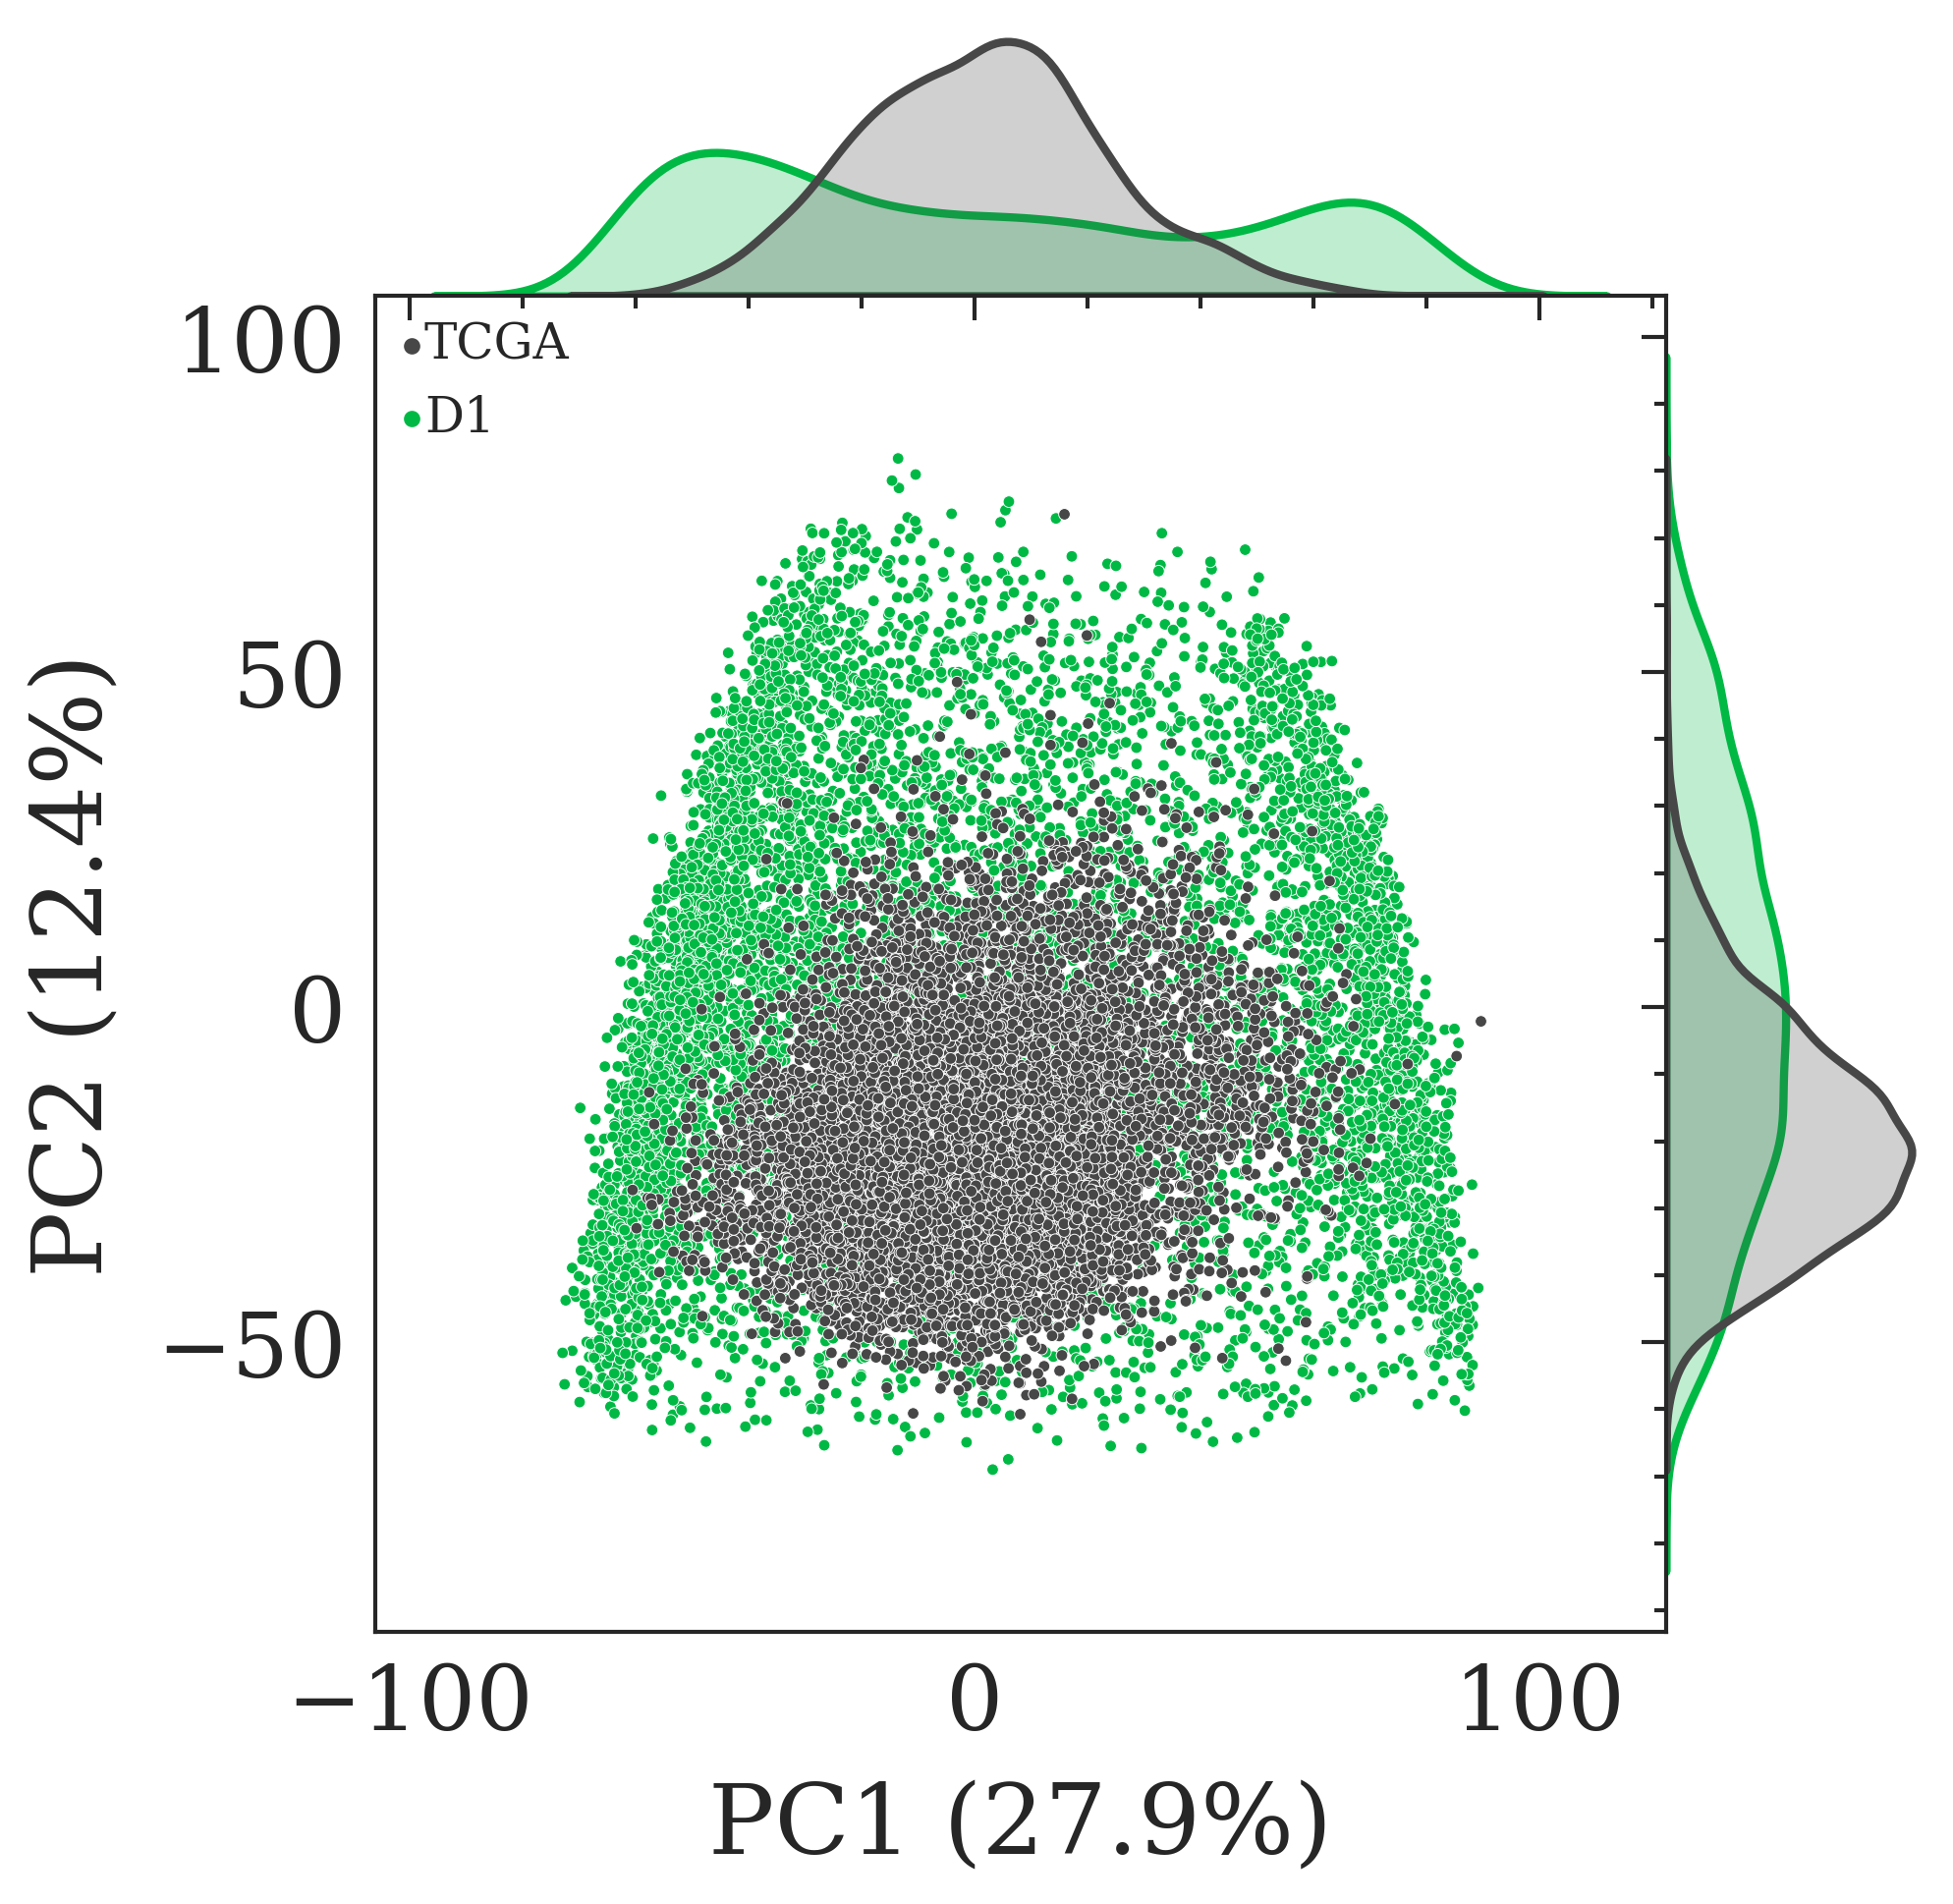

In [16]:
g1 = sns.jointplot(x=f'PC1', y=f'PC2', data=d1_tcga_pca, kind='scatter', 
                   hue='class', s=2, height=3.5, space=0, rasterized=True, palette=dataset2color, hue_order=['TCGA', 'D1'])
g1_ax = g1.ax_joint
g1_ax.set_xticks([-100, 0.0, 100])
g1legend = g1_ax.legend(loc='upper left', fontsize=6, borderpad=0, handletextpad=0)
for _ in g1legend.legendHandles:
    _.set_sizes([1])
# sns.despine(g1_ax)
g1.ax_marg_x.tick_params(axis='x', which='both', top=False)
g1.ax_marg_x.grid(False)
g1.ax_marg_y.tick_params(axis='y', which='both', right=False)
g1.ax_marg_y.grid(False)
g1_ax.set_xlabel(f'PC1 ({val_ratio[0]*100:.1f}%)')
g1_ax.set_ylabel(f'PC2 ({val_ratio[1]*100:.1f}%)')

plt.savefig(os.path.join('./results/E3', f'TCGA_project_to_{simu_ds_name}_PCA.png'), dpi=300)

In [17]:
!tree ./results/E3/

./results/E3/
├── DeSide_running_log.txt
├── TCGA_project_to_D1_PCA.png
└── segment_12ds_0.95_n_base100_19cancer_pca_0.9_median_gep
    ├── D1_PCA.joblib
    ├── Mixed_N10K_segment
    │   ├── Mixed_N10K_segment_PCA_with_TCGA_high_corr_gene_and_quantile_range.csv
    │   ├── Mixed_N10K_segment_PCA_with_TCGA_high_corr_gene_and_quantile_range_PC0_PC1.png
    │   ├── gene_list_filtered_by_high_corr_gene_and_quantile_range.csv
    │   └── gene_list_filtered_by_quantile_range_q_0.5_q_99.5.csv
    ├── generated_frac_Mixed_N10K_segment.csv
    ├── simu_bulk_exp_Mixed_N10K_segment_log2cpm1p.csv
    ├── simu_bulk_exp_Mixed_N10K_segment_log2cpm1p.h5ad
    ├── simu_bulk_exp_Mixed_N10K_segment_log2cpm1p_filtered_by_high_corr_gene_and_quantile_range_q_0.5_q_99.5.h5ad
    └── simu_bulk_exp_Mixed_N10K_segment_sampled_sc_cell_id.csv

3 directories, 12 files


#### Output files
```text
results/E3  # the output folder of this example
|-- DeSide_running_log.txt  # log file
`-- segment_12ds_0.95_n_base100_19cancer_pca_0.9_median_gep
    |-- Mixed_N10K_segment
    |   |-- Mixed_N10K_segment_PCA_with_TCGA_high_corr_gene_and_quantile_range.csv  # Values of the first two principal components (PCs)
    |   |-- Mixed_N10K_segment_PCA_with_TCGA_high_corr_gene_and_quantile_range_PC0_PC1.png  # Visualization of PCA for the generated dataset and TCGA
    |   `-- gene_list_filtered_by_high_corr_gene_and_quantile_range_q_5.0_q_95.0.csv  # Gene list after filtering by correlation and quantile range
    |-- generated_frac_Mixed_N10K_segment.csv  # Cell proportion matrix
    |-- simu_bulk_exp_Mixed_N10K_segment_log2cpm1p.csv  # Generated bulk gene expression profiles (GEPs) without filtering (csv format)
    |-- simu_bulk_exp_Mixed_N10K_segment_log2cpm1p.h5ad  # Generated bulk GEPs without filtering (h5ad format)
    |-- simu_bulk_exp_Mixed_N10K_segment_log2cpm1p_filtered_by_high_corr_gene_and_quantile_range_q_5.0_q_95.0.h5ad  # Generated bulk GEPs after filtering (h5ad format)
    `-- simu_bulk_exp_Mixed_N10K_segment_sampled_sc_cell_id.csv  # Selected single-cell GEPs from dataset S1 during GEP sampling
```